<a href="https://colab.research.google.com/github/anagrd-ai/neural-net-function-solver/blob/main/NN_Function_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

test data: -6.283185307179586, -6.283185307179586  -6.124117324719344, -6.283185307179586 ... 6.283185307179586, 6.283185307179586
      len: 6400, 6400  shape: (6400,), (6400,)
Training results:
 {'loss': [0.34707316756248474, 0.18075603246688843, 0.14325886964797974, 0.13192516565322876, 0.12009111046791077, 0.10141590237617493, 0.08309832960367203, 0.06462982296943665, 0.05203358083963394, 0.03918788209557533, 0.02716958336532116, 0.01675121672451496, 0.010200881399214268, 0.006382578052580357], 'val_loss': [0.24174942076206207, 0.14907607436180115, 0.13493837416172028, 0.161947101354599, 0.13475175201892853, 0.10219995677471161, 0.08613932877779007, 0.07670113444328308, 0.046054963022470474, 0.03672797977924347, 0.02554081380367279, 0.012374487705528736, 0.007439870852977037, 0.004548565950244665]} 

200/200 [==============================] - 0s 1ms/step


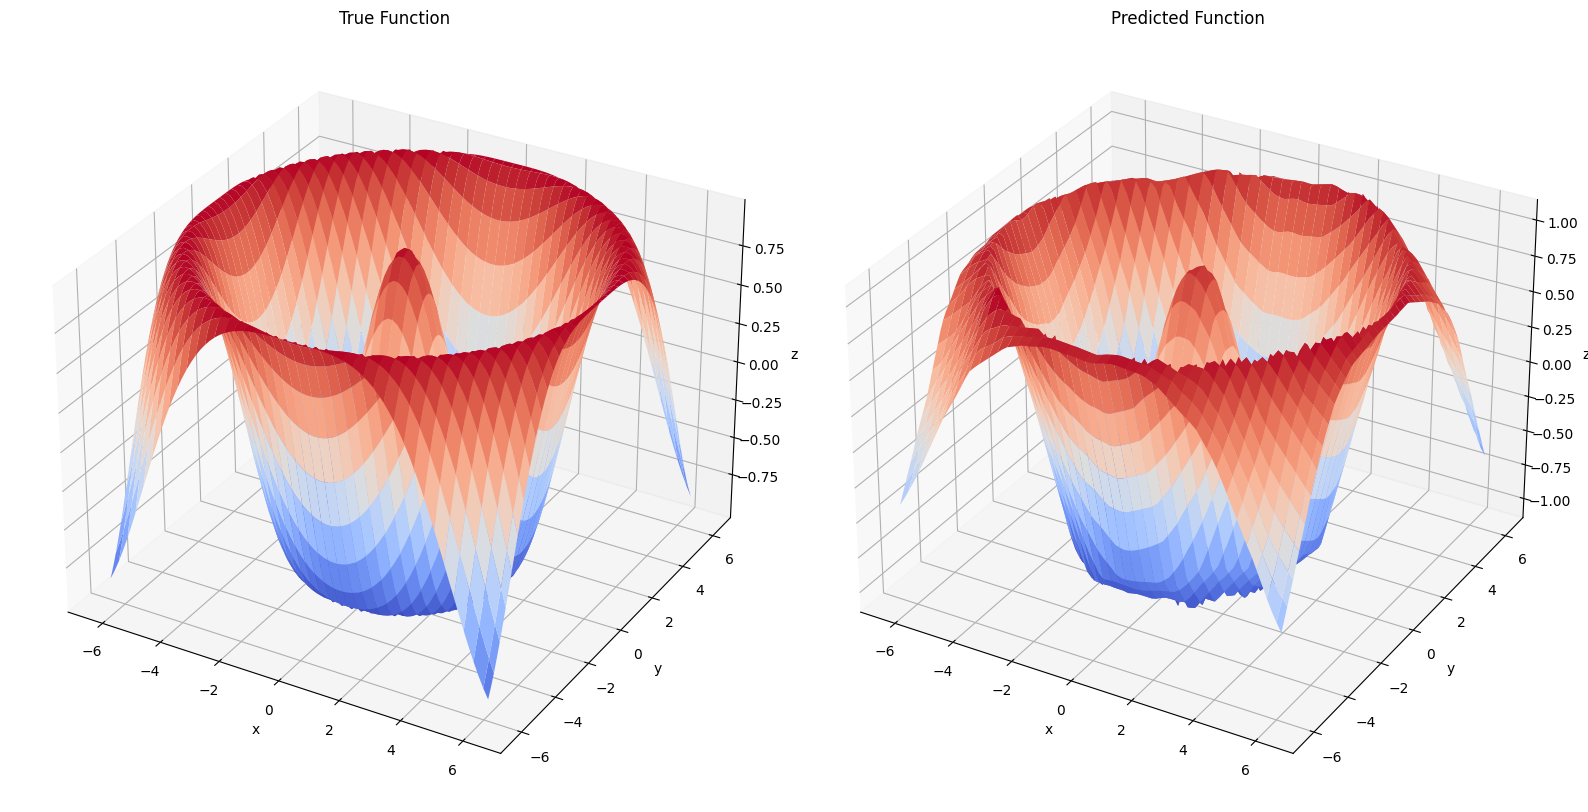

Mean Squared Error: 0.005171383175471311


In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import math

# Generate input (x,y) training data randomly distributed over the 2D space
def generate_xy_random(num_points: int, bounds: float):
    x = np.random.uniform(-bounds, bounds, num_points)
    y = np.random.uniform(-bounds, bounds, num_points)
    return x, y

# Generate evenly spaced x and y coordinates
def generate_xy_even(
    rows: int, cols: int, xlo: float, ylo: float, xhi: float, yhi: float):
    x = np.linspace(xlo, xhi, num=cols, endpoint=True)
    y = np.linspace(ylo, yhi, num=rows, endpoint=True)
    xx, yy = np.meshgrid(x, y)
    return xx.ravel(), yy.ravel()  # same as xx.reshape(-1)

# Generate output (z) training data
def generate_z_data(x, y):
    z = np.cos(np.sqrt(x * x + y * y))
    # z = np.cos(x * y)
    return z

'''
  Create the neural network model.  Uses regression (Supervised Learning model).

  3 layer Sequential NN model:
  1. 64 nodes, ReLU activation, takes 2 input features (x and y)
    Rectified Linear Unit (ReLU) is handy for non-linear functions. f = max(x,0)
  2. 64 node hidden layer
  3. Output layer with linear activation, returns the z = f(x, y) value
  Optimizer: uses Adam, a stochastic gradient descent optimizer
  Loss function: Mean Squared Error (MSE)
'''
def create_model(
    optimizer='adam', loss='mse', neurons=64, hidden_layer_count = 1):
    layers = [
         tf.keras.layers.Dense(neurons, activation='relu', input_shape=(2,))
        ]
    for _ in range(hidden_layer_count):
      layers.append(tf.keras.layers.Dense(neurons, activation='relu'))
    layers.append(tf.keras.layers.Dense(1))

    model = tf.keras.Sequential(layers)
    model.compile(optimizer=optimizer, loss=loss)
    return model

'''
Train the model
We reserve 20% of the data for validation.
'''
def train_model(
    model, xy_train, z_train, xy_val, z_val, epochs=14):
    history = model.fit(
        xy_train,
        z_train,
        epochs=epochs,
        # validation_split = 0.2,  # we provide validation data instead
        validation_data = (xy_val, z_val),
        verbose=0
    )
    return history

# Plot the results
def plot_results(x_test, y_test, z_test, z_pred, rows, cols):
    fig = plt.figure(figsize=(16, 8))

    xx = x_test.reshape((rows, cols))
    yy = y_test.reshape((rows, cols))
    zz_test = z_test.reshape((rows, cols))
    zz_pred = z_pred.reshape((rows, cols))

    ax1 = fig.add_subplot(121, projection='3d')
    # ax1.scatter(x_test, y_test, z_test, c='b', marker=".", label='True')
    ax1.plot_surface(xx, yy, zz_test, cmap=cm.coolwarm, linewidth=0,)
    ax1.set_title('True Function')

    ax2 = fig.add_subplot(122, projection='3d')
    # ax2.scatter(x_test, y_test, z_pred, c='r', marker=".", label='Predicted')
    ax2.plot_surface(xx, yy, zz_pred, cmap=cm.coolwarm, linewidth=0,)
    ax2.set_title('Predicted Function')

    for ax in [ax1, ax2]:
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

    plt.tight_layout()
    plt.show()

# Main function
def main():
    bound = math.pi * 2.0
    rows_test = 80
    cols_test = 80
    # Generate data
    x_train, y_train = generate_xy_random(10000, bound)
    x_val, y_val = generate_xy_random(400, bound)
    # x_test, y_test = generate_xy_random(rows_test * cols_test, bound)

    # x_train, y_train = generate_xy_even(120, 120, -bound, -bound, bound, bound)
    x_test, y_test = generate_xy_even(rows_test, cols_test, -bound, -bound, bound, bound)

    print(f"test data: {x_test[0]}, {y_test[0]}  {x_test[1]}, {y_test[1]} ... {x_test[-1]}, {y_test[-1]}")
    print(f"      len: {len(x_test)}, {len(y_test)}  shape: {x_test.shape}, {y_test.shape}")

    z_train = generate_z_data(x_train, y_train)
    z_test = generate_z_data(x_test, y_test)
    z_val = generate_z_data(x_val, y_val)

    # Create and train the model
    model = create_model()
    xy_train = np.column_stack((x_train, y_train))
    xy_val = np.column_stack((x_val, y_val))
    history = train_model(model, xy_train, z_train, xy_val, z_val)

    print("Training results:\n", history.history, "\n")

    # Make predictions
    z_pred = model.predict(np.column_stack((x_test, y_test))).flatten()

    # Plot the results
    plot_results(x_test, y_test, z_test, z_pred, rows_test, cols_test)

    # Print the mean squared error
    mse = np.mean((z_test - z_pred)**2)
    print(f"Mean Squared Error: {mse}")

if __name__ == "__main__":
    main()